# Data Sanity Checks

In [18]:
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient

import random

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



from concurrent.futures import ProcessPoolExecutor

import copy

In [ ]:
# Import normalized data
with open('03-normalized-data/predictors.pkl', 'rb') as f:
    predictors = pickle.load(f)

baseline_p = predictors[5]

predictors = predictors[:5]



with open('05-edge-metadata/edge_metadata.pkl', 'rb') as f:
    edge_metadata = pickle.load(f)

# Import edgenonedge data
with open('04-edgenonedge-data/edgenonedge_data.pkl', 'rb') as f:
    edgenonedge_data = pickle.load(f)



predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product']



In [20]:
p = 0
g = 0
e = 5
print('Sample edge prediction score:', predictors[p][g][e])

Sample edge prediction score: [0.0060241]


Graph 0: Real edges = 214, Non-edges = 377469
Graph 1: Real edges = 193, Non-edges = 362230
Graph 2: Real edges = 180, Non-edges = 288091
Graph 3: Real edges = 151, Non-edges = 187309
Graph 4: Real edges = 100, Non-edges = 104461
Graph 5: Real edges = 194, Non-edges = 322325
Graph 6: Real edges = 139, Non-edges = 176377
Graph 7: Real edges = 267, Non-edges = 530278
Graph 8: Real edges = 212, Non-edges = 319103
Graph 9: Real edges = 148, Non-edges = 171753
Graph 10: Real edges = 148, Non-edges = 178836
Graph 11: Real edges = 136, Non-edges = 178831
Graph 12: Real edges = 137, Non-edges = 179428
Graph 13: Real edges = 130, Non-edges = 175300
Graph 14: Real edges = 180, Non-edges = 295634
Graph 15: Real edges = 205, Non-edges = 328104
Graph 16: Real edges = 216, Non-edges = 389882
Graph 17: Real edges = 75, Non-edges = 55476
Graph 18: Real edges = 172, Non-edges = 282117
Graph 19: Real edges = 144, Non-edges = 255039
Graph 20: Real edges = 202, Non-edges = 452244
Graph 21: Real edges = 13

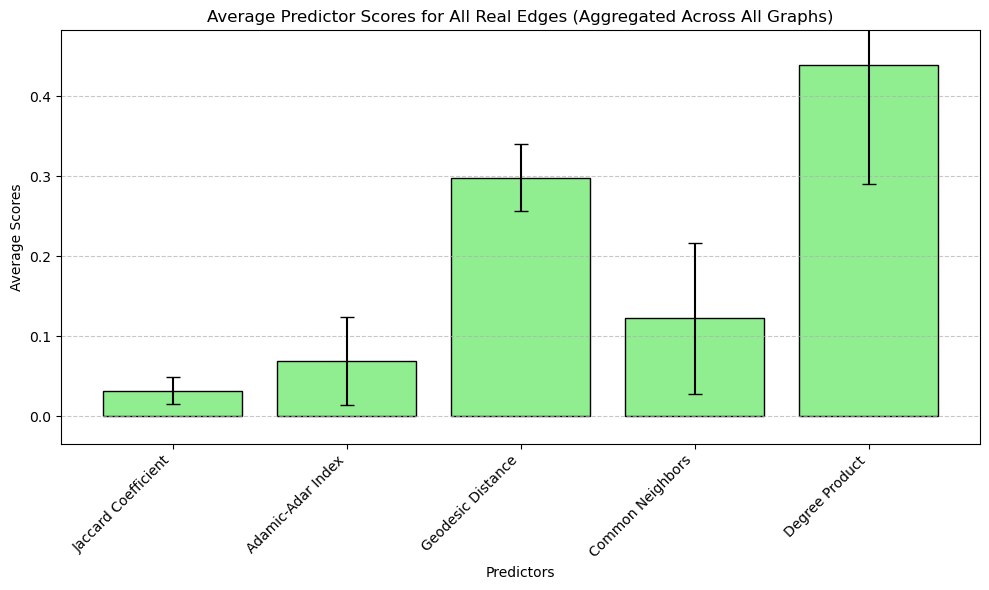

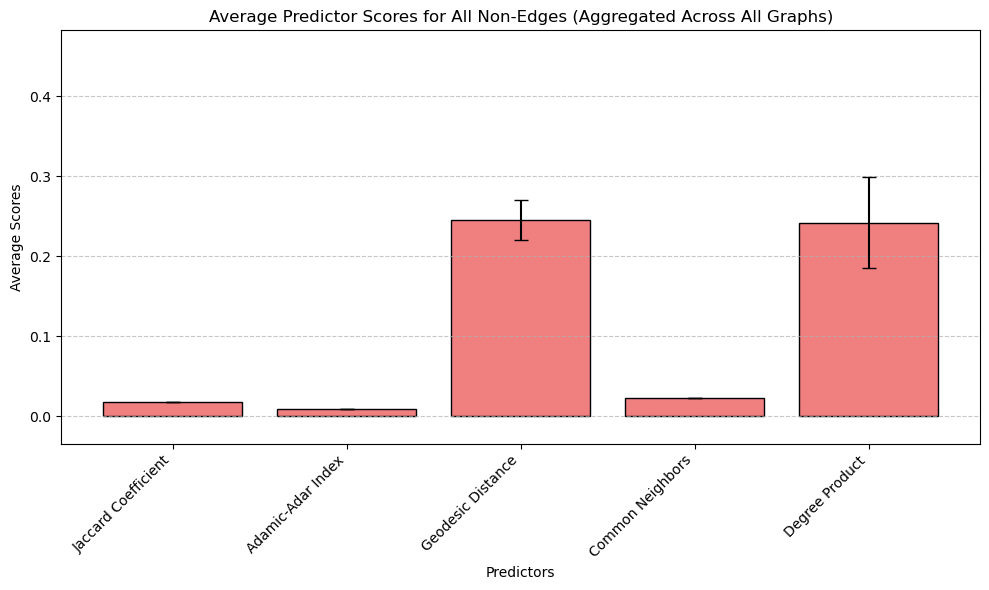

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

# Initialize variables for storing combined scores
all_real_scores = []
all_non_scores = []

# Process all graphs
for g in range(len(predictors[0])):  # Iterate over all graphs
    g1_predictions = np.array([predictor[g] for predictor in predictors])  # Predictor scores for graph g
    g_ene = edgenonedge_data[g].flatten()  # Real edge/non-edge labels for graph g, flattened for consistency

    # Ensure correct shape
    assert g1_predictions.shape[1] == len(g_ene), f"Shape mismatch for graph {g}"

    # Define real and non-edge indices
    real_edge_indices = np.where(g_ene == 1)[0]  # Indices where edges actually exist
    non_edge_indices = np.where(g_ene == 0)[0]  # Indices where edges do not exist

    # Debugging: Print the number of real edges and non-edges for each graph
    print(f"Graph {g}: Real edges = {len(real_edge_indices)}, Non-edges = {len(non_edge_indices)}")

    # Collect all real edge scores
    if len(real_edge_indices) > 0:
        real_scores = np.array([[g1_predictions[i, edge_idx].item() for edge_idx in real_edge_indices] for i in range(len(predictor_names))])
        all_real_scores.append(real_scores)

    # Collect non-edge scores (limit the sample size to the number of real edges for balance)
    if len(non_edge_indices) > 0:
        random_non_indices_sample = np.random.choice(non_edge_indices, size=len(real_edge_indices), replace=False)
        non_scores = np.array([[g1_predictions[i, edge_idx].item() for edge_idx in random_non_indices_sample] for i in range(len(predictor_names))])
        all_non_scores.append(non_scores)

# Combine scores across all graphs
if all_real_scores:
    all_real_scores = np.hstack(all_real_scores)  # Combine all real edge scores horizontally
if all_non_scores:
    all_non_scores = np.hstack(all_non_scores)  # Combine all non-edge scores horizontally

# Sanity check: Ensure we combined scores from all graphs
print(f"Total Real Edge Scores Collected: {all_real_scores.shape[1]} edges")
print(f"Total Non-Edge Scores Collected: {all_non_scores.shape[1]} edges")

# Compute averages and IQRs for each predictor
real_means = all_real_scores.mean(axis=1) if all_real_scores.size > 0 else np.zeros(len(predictor_names))
real_iqrs = np.apply_along_axis(calculate_iqr, axis=1, arr=all_real_scores) if all_real_scores.size > 0 else np.zeros(len(predictor_names))

non_means = all_non_scores.mean(axis=1) if all_non_scores.size > 0 else np.zeros(len(predictor_names))
non_iqrs = np.apply_along_axis(calculate_iqr, axis=1, arr=all_non_scores) if all_non_scores.size > 0 else np.zeros(len(predictor_names))

# Determine unified y-axis limits
y_min = min(real_means.min(), non_means.min())
y_max = max(real_means.max(), non_means.max())
y_margin = 0.1 * (y_max - y_min)  # Add 10% margin for better visualization
y_limits = (y_min - y_margin, y_max + y_margin)

# Bar chart for real edges
plt.figure(figsize=(10, 6))
plt.bar(predictor_names, real_means, yerr=real_iqrs / 2, color='lightgreen', edgecolor='black', capsize=5)
plt.title(f"Average Predictor Scores for All Real Edges (Aggregated Across All Graphs)")
plt.xlabel("Predictors")
plt.ylabel("Average Scores")
plt.ylim(y_limits)  # Set shared y-axis limits
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar chart for non-edges
plt.figure(figsize=(10, 6))
plt.bar(predictor_names, non_means, yerr=non_iqrs / 2, color='lightcoral', edgecolor='black', capsize=5)
plt.title(f"Average Predictor Scores for All Non-Edges (Aggregated Across All Graphs)")
plt.xlabel("Predictors")
plt.ylabel("Average Scores")
plt.ylim(y_limits)  # Set shared y-axis limits
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# For now, use only the first graph

g = 0

g1_predictions = []

for predictor in predictors:
    g1_predictions.append(predictor[g])
g1_predictions = np.array(g1_predictions)

print(g1_predictions.shape)  # Check the shape of the resulting array


g_ene = edgenonedge_data[g]


print(g_ene.shape)  # Check the shape of the resulting array


(5, 377683, 1)
(377683, 1)


In [15]:


# Find the most correct predictor for each edge (column-wise)
most_correct_estimator = []
edge_is_real = g_ene

for i in range(g1_predictions.shape[1]):  # Iterate over each edge (column index)
    if edge_is_real[i]: # If missing edge is an edge in the origional graph
        index = np.argmax(g1_predictions[:, i])  # Find the predictor (row) with the maximum value for the edge
        most_correct_estimator.append(index)
    else:
        index = np.argmin(g1_predictions[:, i])  # Find the predictor (row) with the lowest value for the edge
        most_correct_estimator.append(index)

# Convert the result to a NumPy array
most_correct_estimator = np.array(most_correct_estimator).reshape(-1, 1)



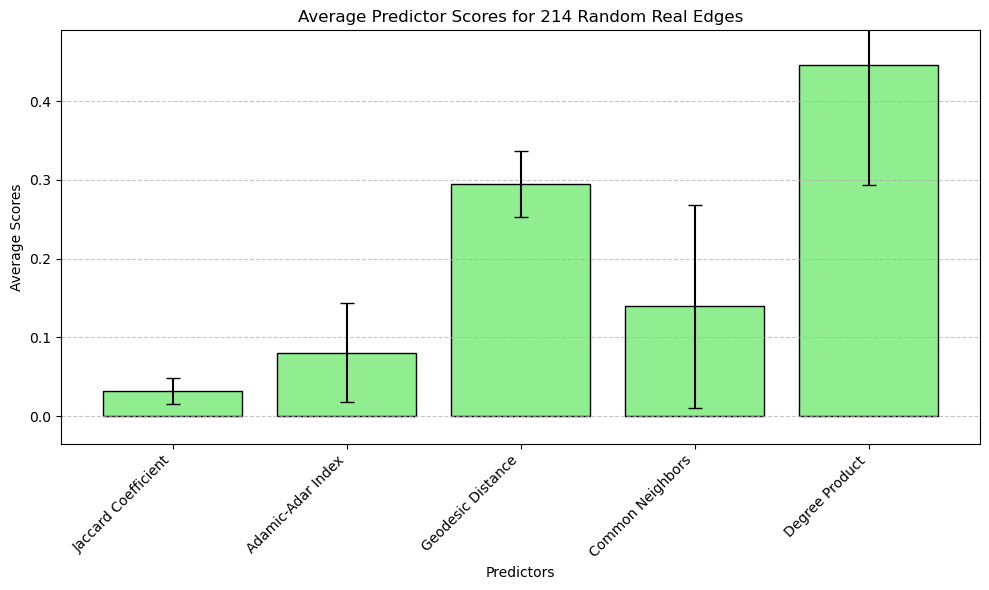

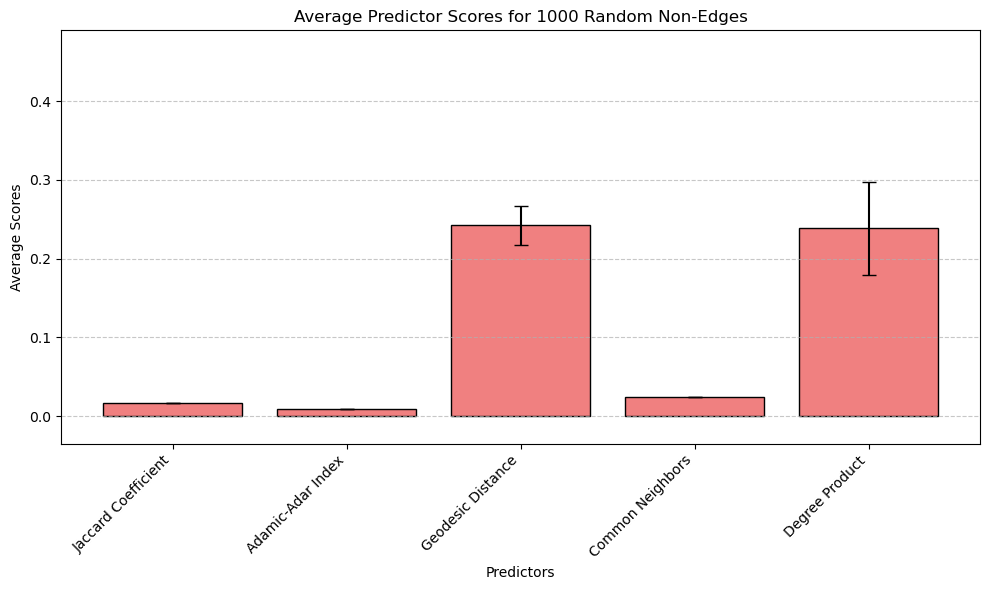

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

# Define real and non-edge indices
real_edge_indices = np.where(edge_is_real)[0]  # Indices where edges actually exist
non_edge_indices = np.where(~edge_is_real)[0]  # Indices where edges do not exist


# Define sample sizes
real_sample_size = min(1000, len(real_edge_indices))
non_sample_size = min(1000, len(non_edge_indices))

# Process for real edges
random_real_indices_sample = np.random.choice(real_edge_indices, size=real_sample_size, replace=False)
real_scores = np.array([[g1_predictions[i, edge_idx].item() for edge_idx in random_real_indices_sample] for i in range(len(predictor_names))])

real_means = real_scores.mean(axis=1)  # Average scores
real_iqrs = np.apply_along_axis(calculate_iqr, axis=1, arr=real_scores)  # IQR for each predictor

# Process for non-edges
random_non_indices_sample = np.random.choice(non_edge_indices, size=non_sample_size, replace=False)
non_scores = np.array([[g1_predictions[i, edge_idx].item() for edge_idx in random_non_indices_sample] for i in range(len(predictor_names))])

non_means = non_scores.mean(axis=1)  # Average scores
non_iqrs = np.apply_along_axis(calculate_iqr, axis=1, arr=non_scores)  # IQR for each predictor

# Determine unified y-axis limits
y_min = min(real_means.min(), non_means.min())
y_max = max(real_means.max(), non_means.max())
y_margin = 0.1 * (y_max - y_min)  # Add 10% margin for better visualization
y_limits = (y_min - y_margin, y_max + y_margin)

# Bar chart for real edges
plt.figure(figsize=(10, 6))
plt.bar(predictor_names, real_means, yerr=real_iqrs / 2, color='lightgreen', edgecolor='black', capsize=5)
plt.title(f"Average Predictor Scores for {real_sample_size} Random Real Edges")
plt.xlabel("Predictors")
plt.ylabel("Average Scores")
plt.ylim(y_limits)  # Set shared y-axis limits
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar chart for non-edges
plt.figure(figsize=(10, 6))
plt.bar(predictor_names, non_means, yerr=non_iqrs / 2, color='lightcoral', edgecolor='black', capsize=5)
plt.title(f"Average Predictor Scores for {non_sample_size} Random Non-Edges")
plt.xlabel("Predictors")
plt.ylabel("Average Scores")
plt.ylim(y_limits)  # Set shared y-axis limits
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

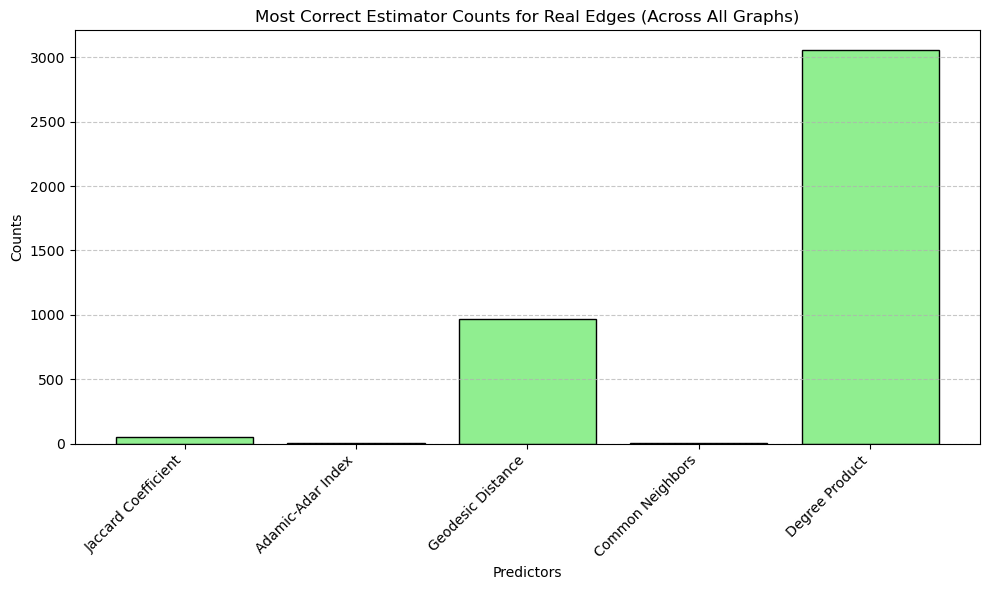

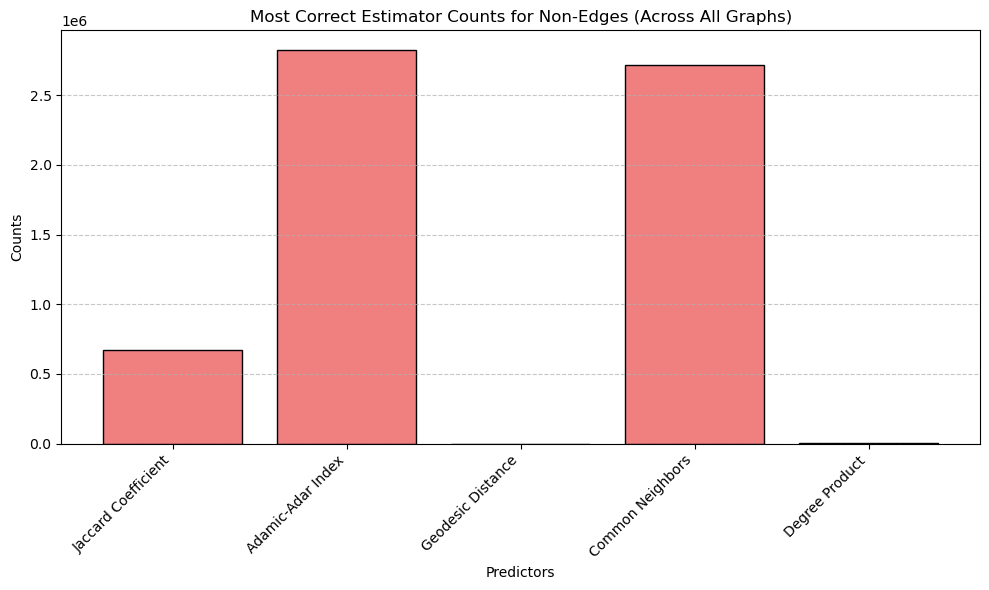


Most Correct Estimator Counts for Real Edges:
Jaccard Coefficient: 49
Adamic-Adar Index: 2
Geodesic Distance: 971
Common Neighbors: 5
Degree Product: 3057

Most Correct Estimator Counts for Non-Edges:
Jaccard Coefficient: 673144
Adamic-Adar Index: 2823673
Geodesic Distance: 129
Common Neighbors: 2713901
Degree Product: 1706


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Initialize counters for most correct estimators (MCEs)
real_mce_counts = Counter()
non_mce_counts = Counter()

# Iterate over all graphs
for g in range(len(edgenonedge_data)):
    # Get predictions and edge labels for graph g
    g1_predictions = np.array([predictor[g] for predictor in predictors])  # Predictor scores for graph g
    g_ene = edgenonedge_data[g].flatten()  # Real edge/non-edge labels for graph g, flattened for consistency

    # Ensure correct shape
    assert g1_predictions.shape[1] == len(g_ene), f"Shape mismatch for graph {g}"

    # Determine the most correct estimator (MCE) for each edge
    for i in range(g1_predictions.shape[1]):  # Iterate over each edge
        if g_ene[i]:  # Real edge
            index = np.argmax(g1_predictions[:, i])  # Predictor with the highest score
            real_mce_counts[index] += 1
        else:  # Non-edge
            index = np.argmin(g1_predictions[:, i])  # Predictor with the lowest score
            non_mce_counts[index] += 1

# Convert counts to lists for plotting
real_mce_keys, real_mce_values = zip(*sorted(real_mce_counts.items()))
non_mce_keys, non_mce_values = zip(*sorted(non_mce_counts.items()))

# Plot for real edges
plt.figure(figsize=(10, 6))
plt.bar([predictor_names[i] for i in real_mce_keys], real_mce_values, color='lightgreen', edgecolor='black')
plt.title("Most Correct Estimator Counts for Real Edges (Across All Graphs)")
plt.xlabel("Predictors")
plt.ylabel("Counts")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for non-edges
plt.figure(figsize=(10, 6))
plt.bar([predictor_names[i] for i in non_mce_keys], non_mce_values, color='lightcoral', edgecolor='black')
plt.title("Most Correct Estimator Counts for Non-Edges (Across All Graphs)")
plt.xlabel("Predictors")
plt.ylabel("Counts")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print counts for debugging
print("\nMost Correct Estimator Counts for Real Edges:")
for predictor, count in zip([predictor_names[i] for i in real_mce_keys], real_mce_values):
    print(f"{predictor}: {count}")

print("\nMost Correct Estimator Counts for Non-Edges:")
for predictor, count in zip([predictor_names[i] for i in non_mce_keys], non_mce_values):
    print(f"{predictor}: {count}")